In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, f1_score, matthews_corrcoef
from skopt import BayesSearchCV
from skopt.space import Real,  Integer
from sklearn.metrics import roc_auc_score
from scipy.stats import sem

import warnings
warnings.filterwarnings("ignore")

clinical_df = pd.read_excel(
    'PCI 2016-2022 final database.xlsx',sheet_name=0,nrows=7442)
survival_df = pd.read_excel(
    'PCI 2016-2022 final database.xlsx',sheet_name=1,nrows=7442)

clinical_df.columns = clinical_df.columns.str.replace("[", "(")
clinical_df.columns = clinical_df.columns.str.replace("]", ")")
survival_df.columns = survival_df.columns.str.replace("[", "(")
survival_df.columns = survival_df.columns.str.replace("]", ")")

print("Clinical data table")
display(clinical_df)
print("Survival data table")
display(survival_df)
print("In hospital death = ",survival_df['In-hospital death'].sum(),"patients")
clinical_df['In-hospital death']=survival_df['In-hospital death']
clinical_df.drop(clinical_df[clinical_df['In-hospital death'] >= 1].index, inplace = True)
survival_df.drop(survival_df[survival_df['In-hospital death'] >= 1].index, inplace = True)
clinical_df.drop('In-hospital death',axis=1,inplace=True)
print("Clinical data table after removal of in-hospital death")
display(clinical_df)
print("Survival data table after removal of in-hospital death")
display(survival_df)

# Analyze CV death or all cause death
CV_death=0

Clinical data table


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Avg.),Uric acid (mg/dL) (First),Uric acid (mg/dL) (Last),Uric acid (mg/dL) (Min.),Uric acid (mg/dL) (Max.),Uric acid (mg/dL) (Count)
0,667810842666812,422148281552015,306187964086387,1,39.756220,0,0,0,0,0,...,5.38,5.38,5.38,1,NaN,NaN,NaN,NaN,NaN,0
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7.28,7.28,7.28,1,NaN,NaN,NaN,NaN,NaN,0
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,7.64,7.64,7.64,1,NaN,NaN,NaN,NaN,NaN,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,7.87,5.42,11.10,14,NaN,NaN,NaN,NaN,NaN,0
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,5.81,5.81,5.81,1,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,6.98,6.98,6.98,1,6.30,6.30,6.30,6.30,6.30,1
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,4.24,4.24,4.24,1,4.96,4.96,4.96,4.96,4.96,1
7439,349936550502890,857771931036678,474160006718779,1,73.883396,0,0,0,0,0,...,9.92,9.92,9.92,1,NaN,NaN,NaN,NaN,NaN,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,5.53,4.99,5.82,3,6.02,6.02,6.02,6.02,6.02,1


Survival data table


,CNP,Nr. Ext.,In-hospital death,Cauza CV,Cauza non-CV,Days,Censor,Days CV,Censor CV,Survival status 6 months,...,Survival status CV 18 months,Survival status CV 2 years,Survival status CV 30 months,Survival status CV 3 years,Survival status CV 42 months,Survival status CV 4 years,Survival status CV 54 months,Survival status CV 5 years,Survival status CV 66 months,Survival status CV 6 years
0,306187964086387,667810842666812,1,1,0,0.000000,1,0.000000,1,1,...,1,1,1,1,1,1,1,1,1,1
1,573331431745647,472404851482187,0,0,1,57.561111,1,57.561111,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,365859696279897,901825898788254,0,0,0,452.589583,0,452.589583,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,972433808768011,709422392096649,0,0,0,1204.632639,0,1204.632639,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1
4,414721060707792,962864992156637,0,0,0,1582.573611,0,1582.573611,0,0,...,0,0,0,0,0,0,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,203293192306338,709952914258558,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0
7438,574694259499259,739081227574047,0,0,0,2317.604167,0,2317.604167,0,0,...,0,0,0,0,0,0,0,0,0,0
7439,474160006718779,349936550502890,0,0,0,1950.474306,0,1950.474306,0,0,...,0,0,0,0,0,0,0,0,-1,-1
7440,848435220082227,622884827571002,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0


In hospital death =  256 patients
Clinical data table after removal of in-hospital death


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Avg.),Uric acid (mg/dL) (First),Uric acid (mg/dL) (Last),Uric acid (mg/dL) (Min.),Uric acid (mg/dL) (Max.),Uric acid (mg/dL) (Count)
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7.28,7.28,7.28,1,NaN,NaN,NaN,NaN,NaN,0
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,7.64,7.64,7.64,1,NaN,NaN,NaN,NaN,NaN,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,7.87,5.42,11.10,14,NaN,NaN,NaN,NaN,NaN,0
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,5.81,5.81,5.81,1,NaN,NaN,NaN,NaN,NaN,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,6.80,6.80,11.71,3,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,6.98,6.98,6.98,1,6.30,6.30,6.30,6.30,6.30,1
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,4.24,4.24,4.24,1,4.96,4.96,4.96,4.96,4.96,1
7439,349936550502890,857771931036678,474160006718779,1,73.883396,0,0,0,0,0,...,9.92,9.92,9.92,1,NaN,NaN,NaN,NaN,NaN,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,5.53,4.99,5.82,3,6.02,6.02,6.02,6.02,6.02,1


Survival data table after removal of in-hospital death


,CNP,Nr. Ext.,In-hospital death,Cauza CV,Cauza non-CV,Days,Censor,Days CV,Censor CV,Survival status 6 months,...,Survival status CV 18 months,Survival status CV 2 years,Survival status CV 30 months,Survival status CV 3 years,Survival status CV 42 months,Survival status CV 4 years,Survival status CV 54 months,Survival status CV 5 years,Survival status CV 66 months,Survival status CV 6 years
1,573331431745647,472404851482187,0,0,1,57.561111,1,57.561111,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,365859696279897,901825898788254,0,0,0,452.589583,0,452.589583,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,972433808768011,709422392096649,0,0,0,1204.632639,0,1204.632639,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1
4,414721060707792,962864992156637,0,0,0,1582.573611,0,1582.573611,0,0,...,0,0,0,0,0,0,-1,-1,-1,-1
5,132498628731573,916435896905189,0,1,0,1087.605556,1,1087.605556,1,0,...,0,0,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,203293192306338,709952914258558,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0
7438,574694259499259,739081227574047,0,0,0,2317.604167,0,2317.604167,0,0,...,0,0,0,0,0,0,0,0,0,0
7439,474160006718779,349936550502890,0,0,0,1950.474306,0,1950.474306,0,0,...,0,0,0,0,0,0,0,0,-1,-1
7440,848435220082227,622884827571002,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Avg.),Uric acid (mg/dL) (First),Uric acid (mg/dL) (Last),Uric acid (mg/dL) (Min.),Uric acid (mg/dL) (Max.),Uric acid (mg/dL) (Count)
count,7.186000e+03,7.186000e+03,7.186000e+03,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,...,6994.000000,6994.000000,6994.000000,7186.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,7186.000000
mean,5.463473e+14,5.507207e+14,5.475875e+14,0.705260,64.171358,0.215558,0.027693,0.262037,0.068188,0.114111,...,8.046693,7.746897,9.279385,2.081826,6.346866,6.354053,6.342540,6.303766,6.390646,0.542583
std,2.607721e+14,2.575478e+14,2.631172e+14,0.455957,10.458343,0.411238,0.164102,0.439773,0.252086,0.317968,...,2.657440,2.313949,4.281141,2.421600,1.799818,1.811991,1.816939,1.806860,1.829825,0.648479
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.830000,0.540000,2.440000,0.000000,0.300000,0.300000,0.300000,0.300000,0.300000,0.000000
25%,3.206114e+14,3.282664e+14,3.173585e+14,0.000000,57.439255,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.470000,6.240000,6.930000,1.000000,5.082500,5.090000,5.070000,5.030000,5.100000,0.000000
50%,5.453212e+14,5.481059e+14,5.428970e+14,1.000000,64.900029,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.745000,7.490000,8.440000,1.000000,6.200000,6.200000,6.200000,6.160000,6.240000,0.000000
75%,7.726691e+14,7.748501e+14,7.831067e+14,1.000000,71.685897,0.000000,0.000000,1.000000,0.000000,0.000000,...,9.250000,8.930000,10.600000,2.000000,7.400000,7.400000,7.400000,7.367500,7.460000,1.000000
max,9.997399e+14,9.999622e+14,9.997525e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,113.690000,60.640000,159.120000,44.000000,16.480000,16.480000,16.480000,16.480000,16.480000,15.000000


<Axes: >

Alkaline phosphatase (U/L) (Max.)     7096
Alkaline phosphatase (U/L) (Min.)     7096
Alkaline phosphatase (U/L) (Last)     7096
Alkaline phosphatase (U/L) (First)    7096
Alkaline phosphatase (U/L) (Avg.)     7096
Iron (µg/dL) (Avg.)                   7000
Iron (µg/dL) (Last)                   7000
Iron (µg/dL) (First)                  7000
Iron (µg/dL) (Max.)                   7000
Iron (µg/dL) (Min.)                   7000
dtype: int64

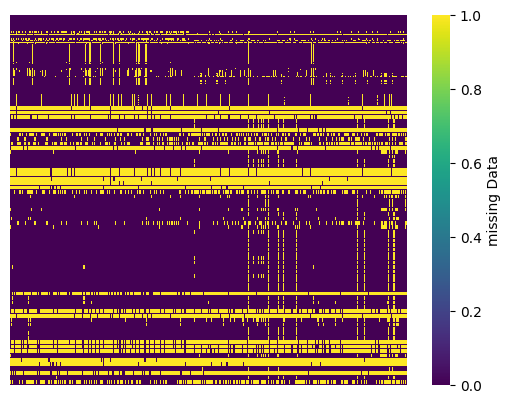

In [2]:
display(clinical_df.describe(include='all'))
display(sns.heatmap(clinical_df.isnull().transpose(),cmap="viridis", cbar_kws={"label": 'missing Data'}, xticklabels=False, yticklabels=False))
display(clinical_df.isnull().sum().sort_values(ascending=False).head(10))

### Removing columns with more than 40% missing data

,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Max.),Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count)
count,7.186000e+03,7.186000e+03,7.186000e+03,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,...,7123.000000,7186.000000,7186.000000,6994.000000,6994.000000,6994.000000,6994.000000,6994.000000,7186.000000,7186.000000
mean,5.463473e+14,5.507207e+14,5.475875e+14,0.705260,64.171358,0.215558,0.027693,0.262037,0.068188,0.114111,...,45.924647,3.241024,0.153771,8.442674,8.891763,8.046693,7.746897,9.279385,2.081826,0.542583
std,2.607721e+14,2.575478e+14,2.631172e+14,0.455957,10.458343,0.411238,0.164102,0.439773,0.252086,0.317968,...,27.591800,2.687805,0.580006,2.857145,4.053641,2.657440,2.313949,4.281141,2.421600,0.648479
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,0.000000,0.000000,2.060000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000
25%,3.206114e+14,3.282664e+14,3.173585e+14,0.000000,57.439255,0.000000,0.000000,0.000000,0.000000,0.000000,...,30.220000,2.000000,0.000000,6.690000,6.660000,6.470000,6.240000,6.930000,1.000000,0.000000
50%,5.453212e+14,5.481059e+14,5.428970e+14,1.000000,64.900029,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,3.000000,0.000000,8.055000,8.180000,7.745000,7.490000,8.440000,1.000000,0.000000
75%,7.726691e+14,7.748501e+14,7.831067e+14,1.000000,71.685897,0.000000,0.000000,1.000000,0.000000,0.000000,...,51.000000,4.000000,0.000000,9.740000,10.170000,9.250000,8.930000,10.600000,2.000000,1.000000
max,9.997399e+14,9.999622e+14,9.997525e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,357.000000,44.000000,14.000000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Max.),Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count)
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,107.0,7,0,7.28,7.28,7.28,7.28,7.28,1,0
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,NaN,0,0,7.64,7.64,7.64,7.64,7.64,1,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,188.0,9,4,8.92,8.22,7.87,5.42,11.10,14,0
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,39.0,3,0,5.81,5.81,5.81,5.81,5.81,1,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,50.3,5,0,8.93,11.71,6.80,6.80,11.71,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,43.0,2,0,6.98,6.98,6.98,6.98,6.98,1,1
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,28.0,2,0,4.24,4.24,4.24,4.24,4.24,1,1
7439,349936550502890,857771931036678,474160006718779,1,73.883396,0,0,0,0,0,...,36.0,2,0,9.92,9.92,9.92,9.92,9.92,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,32.0,2,1,5.45,4.99,5.53,4.99,5.82,3,1


<Axes: >

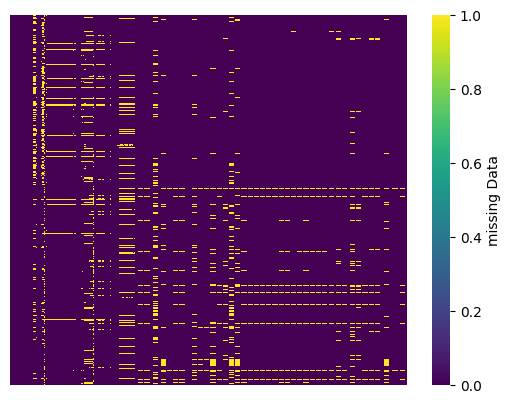

In [3]:
def drop_columns_with_missing_data(df, threshold_percent):
    threshold_count = len(df) * threshold_percent / 100.0

    df_cleaned = df.dropna(axis=1, thresh=(len(df) - threshold_count))
    
    return df_cleaned

threshold_percent = 40
clinical_df = drop_columns_with_missing_data(clinical_df, threshold_percent)
display(clinical_df.describe(include='all'))
display(clinical_df)
display(sns.heatmap(clinical_df.isnull(),cmap="viridis", cbar_kws={"label": 'missing Data'}, xticklabels=False, yticklabels=False))

### No missing data in survival data

,CNP,Nr. Ext.,In-hospital death,Cauza CV,Cauza non-CV,Days,Censor,Days CV,Censor CV,Survival status 6 months,...,Survival status CV 18 months,Survival status CV 2 years,Survival status CV 30 months,Survival status CV 3 years,Survival status CV 42 months,Survival status CV 4 years,Survival status CV 54 months,Survival status CV 5 years,Survival status CV 66 months,Survival status CV 6 years
count,7.186000e+03,7.186000e+03,7186.0,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,...,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000
mean,5.475875e+14,5.463473e+14,0.0,0.118703,0.054272,1449.984725,0.172975,1449.984725,0.118703,0.026997,...,-0.090454,-0.131088,-0.170749,-0.195937,-0.226969,-0.279015,-0.342332,-0.403562,-0.472307,-0.540217
std,2.631172e+14,2.607721e+14,0.0,0.323461,0.226570,776.162753,0.378252,776.162753,0.323461,0.162086,...,0.417302,0.473738,0.522492,0.555622,0.588076,0.621755,0.652799,0.673555,0.686989,0.691018
min,1.000373e+14,1.001593e+14,0.0,0.000000,0.000000,-0.416667,0.000000,-0.416667,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3.173585e+14,3.206114e+14,0.0,0.000000,0.000000,740.885417,0.000000,740.885417,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,5.428970e+14,5.453212e+14,0.0,0.000000,0.000000,1519.092708,0.000000,1519.092708,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000
75%,7.831067e+14,7.726691e+14,0.0,0.000000,0.000000,2117.526736,0.000000,2117.526736,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.997525e+14,9.997399e+14,0.0,1.000000,1.000000,2737.666667,1.000000,2737.666667,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

CNP                             0
Survival status 54 months       0
Survival status CV 66 months    0
Survival status CV 5 years      0
Survival status CV 54 months    0
Survival status CV 4 years      0
Survival status CV 42 months    0
Survival status CV 3 years      0
Survival status CV 30 months    0
Survival status CV 2 years      0
dtype: int64

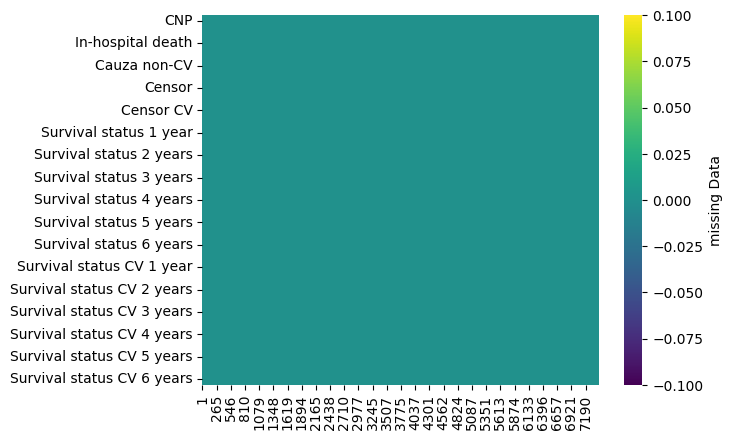

In [4]:
display(survival_df.describe(include='all'))
display(sns.heatmap(survival_df.isnull().transpose(),cmap="viridis", cbar_kws={"label": 'missing Data'}))
display(survival_df.isnull().sum().sort_values(ascending=False).head(10))

## Supporting functions

In [5]:
def bayesian_search(df):

    X    = df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y    = df['Outcome']

    search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(3, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'),
                 'reg_lambda': Real(1e-9, 100., 'uniform'),
                 'reg_alpha': Real(1e-9, 100., 'uniform'),
                 'n_estimators': Integer(50, 5000)
   }
    bayes_search = BayesSearchCV(estimator=xgb.XGBClassifier(eval_metric='auc'), verbose=1,search_spaces=search_spaces,n_points=5,n_jobs=10, cv=5, n_iter=150)

    bayes_search.fit(X,y)  
    best_params = bayes_search.best_params_
    print(best_params)
    return best_params

def train_model_with_bayesian_search(df,best_params):
    count_1 = df[df['Outcome'] == 1].shape[0]
    count_0 = df[df['Outcome'] == 0].shape[0]
    ratio = int(count_0 / count_1)
    unique_patients = df['CNP'].unique()
    f2345, f1 = train_test_split(unique_patients, test_size=0.20, random_state=12)
    f1_df = df[df['CNP'].isin(f1)]
    f2345_df = df[df['CNP'].isin(f2345)]
    unique_patients = f2345_df['CNP'].unique()

    f345, f2 = train_test_split(unique_patients, test_size=0.25, random_state=12)
    f2_df = df[df['CNP'].isin(f2)]
    f345_df = df[df['CNP'].isin(f345)]
    unique_patients = f345_df['CNP'].unique()

    f45, f3 = train_test_split(unique_patients, test_size=0.33, random_state=12)
    f3_df = df[df['CNP'].isin(f3)]
    f45_df = df[df['CNP'].isin(f45)]
    unique_patients = f45_df['CNP'].unique()

    f5, f4 = train_test_split(unique_patients, test_size=0.50, random_state=12)
    f4_df = df[df['CNP'].isin(f4)]
    f5_df = df[df['CNP'].isin(f5)]

    X_f1 = f1_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f1 = f1_df['Outcome']
    X_f2 = f2_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f2 = f2_df['Outcome']
    X_f3 = f3_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f3 = f3_df['Outcome']
    X_f4 = f4_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f4 = f4_df['Outcome']
    X_f5 = f5_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f5 = f5_df['Outcome']

    model = xgb.XGBClassifier(**best_params,scale_pos_weight=ratio)
    model.fit(X_f1, y_f1)
    model.fit(X_f2, y_f2)
    model.fit(X_f3, y_f3)
    model.fit(X_f4, y_f4)
    model.fit(X_f5, y_f5)

    return model

def save_model(model, file_path):
    try:
        joblib.dump(model, file_path)
        print(f"Model saved to {file_path}")
    except Exception as e:
        print(f"Error while saving the model: {e}")

In [6]:
def compute_bootstrapped_AUC_ROC_CI (y_true,y_pred):
    n_bootstraps = 1000
    rng_seed = 42  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        score = roc_auc_score(np.take(y_true,indices), np.take(y_pred,indices))
        bootstrapped_scores.append(score)        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lowerML = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upperML = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the ML: [{:0.3f} - {:0.3}]".format(
        confidence_lowerML, confidence_upperML))
    return confidence_lowerML, confidence_upperML

def compute_bootstrapped_AUC_PR_CI(precision_values, recall_values, num_bootstraps=1000, ci_level=0.95):
    pr_curves = []
    for _ in range(num_bootstraps):
        idx = np.random.choice(len(precision_values), len(precision_values), replace=True)
        bootstrap_precision = np.array(precision_values)[idx]
        bootstrap_recall = np.array(recall_values)[idx]
        sorted_idx = np.argsort(bootstrap_recall)
        sorted_precision = bootstrap_precision[sorted_idx]
        sorted_recall = bootstrap_recall[sorted_idx]
        pr_curves.append((sorted_recall, sorted_precision))
    auc_scores = [auc(recall_curve, precision_curve) for recall_curve, precision_curve in pr_curves]
    auc_scores.sort()
    ci_lower = auc_scores[int((1 - ci_level) / 2 * num_bootstraps)]
    ci_upper = auc_scores[int((1 + ci_level) / 2 * num_bootstraps)] 
    return ci_lower, ci_upper

def calculate_youden_cutoff(true_positive_rates, false_positive_rates, thresholds):
    youden_values = true_positive_rates - false_positive_rates
    max_youden_index = np.argmax(youden_values)
    optimal_youden = thresholds[max_youden_index]
    return optimal_youden

def brier_skill_score(observed, forecast):
    climatology = np.mean(observed)
    bs = np.mean((forecast - observed)**2)
    bs_ref = np.mean((climatology - observed)**2)
    bss = 1 - (bs / bs_ref)
    return bss

In [7]:
import os
def append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                         No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        months,timeframe, auc_roc_train,upper_roc_train, lower_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation,
                        youden, matthews_corrcoef_train, matthews_corrcoef_validation, f1_score_train, f1_score_validation, brier_score_loss_train, brier_score_loss_validation,
                        brier_skill_score_train, brier_skill_score_validation):
    row=({
        'Timeframe': [timeframe],
        'Months': [months],

        "No_total_hospitalizations": [ No_total_hospitalizations],
        "No_unique_patients": [ No_unique_patients],
        "No_total_events": [ No_total_events],
        
        "No_training_hospitalizations": [ No_training_hospitalizations],
        "No_training_patients": [ No_training_patients],
        "No_training_events": [ No_training_events],

        "No_validation_hospitalizations": [ No_validation_hospitalizations],
        "No_validation_patients": [ No_validation_patients],
        "No_validation_events": [ No_validation_events],
           
        'auc_roc_train': [auc_roc_train],
        'lower_roc_train': [lower_roc_train],
        "upper_roc_train": [upper_roc_train],
        "auc_roc_validation": [auc_roc_validation],
        "lower_roc_validation": [ lower_roc_validation],
        "upper_roc_validation": [ upper_roc_validation],
        "auc_pr_train": [ auc_pr_train],
        "lower_pr_train": [ lower_pr_train],
        "upper_pr_train": [upper_pr_train],
        "auc_pr_validation": [ auc_pr_validation],
        "lower_pr_validation": [ lower_pr_validation],
        "upper_pr_validation": [ upper_pr_validation],
        "Youden cut-off": [youden],
        "MCC train": [matthews_corrcoef_train],
        "MCC validation": [matthews_corrcoef_validation],
        "F1 train": [ f1_score_train],
        "F1 validation": [ f1_score_validation],
        "BS train": [brier_score_loss_train],
        "BS validation": [brier_score_loss_validation],
        "BSS train": [brier_skill_score_train],
        "BSS validation": [brier_skill_score_validation],
    })
    dataframe = pd.DataFrame(row)
    csv_file_path='result.csv'
    if os.path.exists(csv_file_path):
        existing_data = pd.read_csv(csv_file_path)
        combined_data = pd.concat([existing_data, dataframe], ignore_index=True)
    else:
        combined_data = dataframe
    combined_data.to_csv(csv_file_path, index=False)
    
    

## Bayesian search of best hyperparameters on 6 years data

In [8]:
working_df_6y=clinical_df.copy()

if CV_death==0:
    working_df_6y['Outcome']=survival_df['Survival status 6 years']
else:
    working_df_6y['Outcome']=survival_df['Survival status CV 6 years']
working_df_6y.drop(working_df_6y[working_df_6y['Outcome'] <= -1].index, inplace = True)

unique_patients = working_df_6y['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df_6y[working_df_6y['CNP'].isin(train_patients)]

best_params=bayesian_search(training_testing_df)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates

In [9]:
import pickle
def save_to_file(variable, filename):
    with open(filename, 'wb') as file:
        pickle.dump(variable, file)

def load_from_file(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

save_to_file(best_params, 'best_params.pkl')
best_params = load_from_file('best_params.pkl')
print("Loaded data from file:", best_params)

Loaded data from file: OrderedDict([('colsample_bytree', 0.3222909297507306), ('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 5000), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('subsample', 0.8360191510450623)])


## Survival at 6 months

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,0,0,7.64,7.64,7.64,7.64,7.64,1,0,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
7,157877497192414,204398183505829,717689241032262,1,84.036800,0,0,0,0,0,...,5,0,8.33,9.29,6.98,6.98,9.29,5,3,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,5.014000e+03,5.014000e+03,5.014000e+03,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000,...,5014.000000,5014.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,5014.000000,5014.000000,5014.000000
mean,5.472246e+14,5.497724e+14,5.476114e+14,0.699242,64.368549,0.215796,0.027922,0.263462,0.063223,0.116673,...,3.255684,0.162545,8.487480,8.957660,8.080334,7.783033,9.349473,2.095333,0.549262,0.027323
std,2.605452e+14,2.581170e+14,2.628404e+14,0.458633,10.378199,0.411414,0.164765,0.440555,0.243388,0.321063,...,2.708978,0.616051,3.024842,4.392738,2.816304,2.382520,4.614860,2.502838,0.655705,0.163041
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.060000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.230941e+14,3.256209e+14,3.180619e+14,0.000000,57.667988,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.720000,6.700000,6.490000,6.270000,6.950000,1.000000,0.000000,0.000000
50%,5.448843e+14,5.445047e+14,5.407178e+14,1.000000,65.109703,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,8.070000,8.200000,7.770000,7.510000,8.450000,1.000000,1.000000,0.000000
75%,7.721976e+14,7.733314e+14,7.831679e+14,1.000000,71.845107,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.770000,10.220000,9.250000,8.930000,10.640000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,14.000000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 137
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.172000e+03,2.172000e+03,2.172000e+03,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,...,2172.000000,2172.000000,2117.000000,2117.000000,2117.000000,2117.000000,2117.000000,2172.000000,2172.000000,2172.000000
mean,5.443220e+14,5.529099e+14,5.475324e+14,0.719153,63.716149,0.215009,0.027164,0.258748,0.079650,0.108195,...,3.207182,0.133517,8.339452,8.739953,7.969192,7.663651,9.117922,2.050645,0.527164,0.026243
std,2.613442e+14,2.562749e+14,2.638158e+14,0.449516,10.629496,0.410923,0.162598,0.438048,0.270813,0.310698,...,2.638583,0.486236,2.424634,3.131571,2.247864,2.145894,3.385018,2.222993,0.631361,0.159894
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,1.960000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.127294e+14,3.360937e+14,3.126874e+14,0.000000,56.705878,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.610000,6.590000,6.400000,6.180000,6.850000,1.000000,0.000000,0.000000
50%,5.466285e+14,5.552496e+14,5.511831e+14,1.000000,64.457757,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,8.010000,8.110000,7.690000,7.440000,8.380000,1.000000,0.000000,0.000000
75%,7.733111e+14,7.779819e+14,7.813999e+14,1.000000,71.213173,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.650000,10.080000,9.250000,8.930000,10.460000,2.000000,1.000000,0.000000
max,9.997399e+14,9.990023e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 57
Model saved to 0.5y_model.pkl
Confidence interval for the ML: [0.826 - 0.879]
Confidence interval for the ML: [0.759 - 0.848]


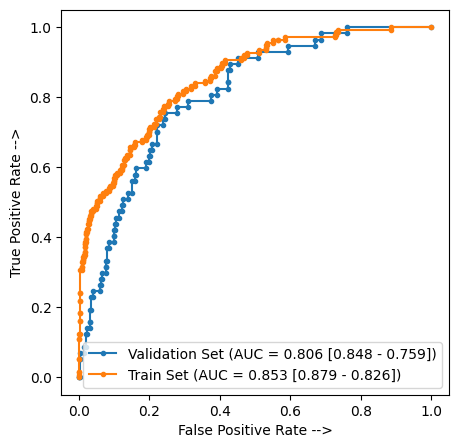

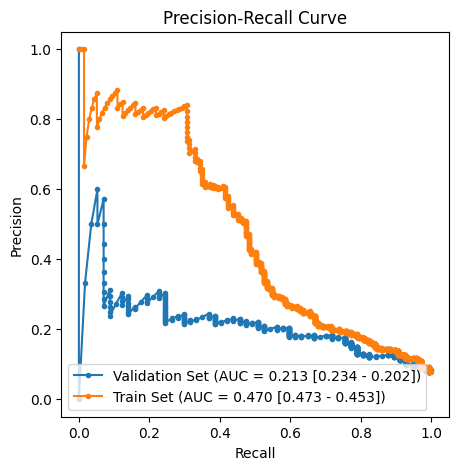

Youden cut-off =  0.03158746
BS train =  0.0479469187747726
BS validation =  0.05750225719753325
BSS train =  0.2530971065216999
BSS validation =  0.0567846803877492
F1 train =  0.3004172461752434
F1 validation =  0.25280898876404495
MCC train =  0.29624006459507163
MCC validation =  0.24907700815780723


In [10]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 6 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 6 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "0.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('0.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        6,"0.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 1 year

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,0,0,7.64,7.64,7.64,7.64,7.64,1,0,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
7,157877497192414,204398183505829,717689241032262,1,84.036800,0,0,0,0,0,...,5,0,8.33,9.29,6.98,6.98,9.29,5,3,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,4.712000e+03,4.712000e+03,4.712000e+03,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,...,4712.000000,4712.000000,4577.000000,4577.000000,4577.000000,4577.000000,4577.000000,4712.000000,4712.000000,4712.000000
mean,5.456653e+14,5.495414e+14,5.476252e+14,0.700764,64.332283,0.225170,0.029075,0.271859,0.062818,0.116299,...,3.230051,0.146222,8.462845,8.920677,8.068975,7.776989,9.298486,2.050934,0.543506,0.050085
std,2.604339e+14,2.588693e+14,2.629039e+14,0.457972,10.338432,0.417738,0.168034,0.444965,0.242662,0.320617,...,2.727745,0.607784,3.054641,4.441387,2.849905,2.395654,4.662247,2.486806,0.646838,0.218143
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.060000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.216623e+14,3.245483e+14,3.176222e+14,0.000000,57.769471,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.700000,6.670000,6.480000,6.270000,6.920000,1.000000,0.000000,0.000000
50%,5.428508e+14,5.443128e+14,5.414868e+14,1.000000,65.031076,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,8.040000,8.180000,7.750000,7.500000,8.420000,1.000000,1.000000,0.000000
75%,7.699937e+14,7.729606e+14,7.831920e+14,1.000000,71.737371,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.750000,10.170000,9.240000,8.930000,10.590000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,14.000000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 236
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.054000e+03,2.054000e+03,2.054000e+03,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,...,2054.000000,2054.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,2054.000000,2054.000000,2054.000000
mean,5.446804e+14,5.528362e+14,5.473141e+14,0.722980,63.722245,0.223466,0.027751,0.262415,0.077897,0.109056,...,3.194742,0.122687,8.325283,8.727779,7.951446,7.655473,9.101241,2.042356,0.521422,0.042843
std,2.615876e+14,2.556215e+14,2.630238e+14,0.447636,10.609623,0.416670,0.164298,0.440054,0.268074,0.311785,...,2.684416,0.475960,2.432748,3.155407,2.254739,2.147803,3.412865,2.265104,0.631437,0.202553
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.132244e+14,3.391664e+14,3.126874e+14,0.000000,56.910097,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.570000,6.555000,6.380000,6.160000,6.810000,1.000000,0.000000,0.000000
50%,5.467410e+14,5.547955e+14,5.511831e+14,1.000000,64.503936,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.980000,8.110000,7.650000,7.430000,8.370000,1.000000,0.000000,0.000000
75%,7.747898e+14,7.763908e+14,7.804886e+14,1.000000,71.058175,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.635000,10.075000,9.225000,8.915000,10.425000,2.000000,1.000000,0.000000
max,9.997399e+14,9.990023e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 88
Model saved to 1y_model.pkl
Confidence interval for the ML: [0.833 - 0.876]
Confidence interval for the ML: [0.789 - 0.862]


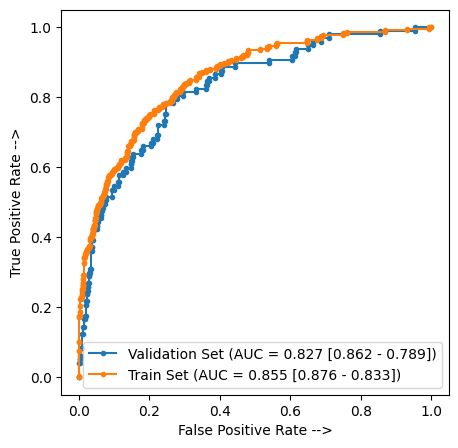

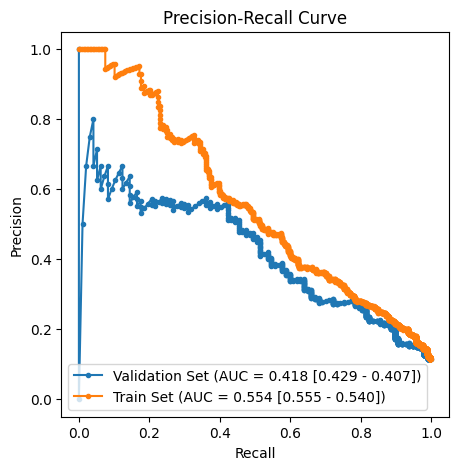

Youden cut-off =  0.06088491
BS train =  0.07405347456087295
BS validation =  0.07954226423495893
BSS train =  0.2681827377765138
BSS validation =  0.1938273476529676
F1 train =  0.45478723404255317
F1 validation =  0.39999999999999997
MCC train =  0.3983702011959811
MCC validation =  0.3366984945800533


In [11]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 1 year']
else:
    working_df['Outcome']=survival_df['Survival status CV 1 year']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "1y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('1y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        12,"1y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 1.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
11,293980352493624,575119259563355,218759704099816,0,49.614536,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,4.398000e+03,4.398000e+03,4.398000e+03,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,...,4398.000000,4398.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4398.000000,4398.000000,4398.000000
mean,5.457958e+14,5.503049e+14,5.462576e+14,0.700091,64.327711,0.237153,0.030241,0.281946,0.063665,0.115734,...,3.193497,0.139836,8.445042,8.892432,8.062270,7.777915,9.262985,2.011369,0.540928,0.070714
std,2.597887e+14,2.593384e+14,2.628234e+14,0.458270,10.329481,0.425385,0.171269,0.449998,0.244184,0.319943,...,2.754628,0.608297,3.094287,4.516218,2.892036,2.420404,4.735662,2.505188,0.641973,0.256376
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.229565e+14,3.247216e+14,3.173458e+14,0.000000,57.855186,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.690000,6.660000,6.480000,6.280000,6.907500,1.000000,0.000000,0.000000
50%,5.416871e+14,5.457884e+14,5.403606e+14,1.000000,64.971426,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,8.010000,8.140000,7.730000,7.500000,8.365000,1.000000,1.000000,0.000000
75%,7.704408e+14,7.743797e+14,7.798655e+14,1.000000,71.704404,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.702500,10.100000,9.212500,8.912500,10.502500,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,14.000000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 311
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.919000e+03,1.919000e+03,1.919000e+03,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,...,1919.000000,1919.000000,1864.000000,1864.000000,1864.000000,1864.000000,1864.000000,1919.000000,1919.000000,1919.000000
mean,5.459588e+14,5.520736e+14,5.498683e+14,0.725378,63.655870,0.235018,0.029703,0.274101,0.076602,0.109953,...,3.168317,0.118812,8.305681,8.703246,7.931781,7.651905,9.055982,2.000521,0.516415,0.067744
std,2.614037e+14,2.544813e+14,2.631956e+14,0.446440,10.651529,0.424121,0.169811,0.446176,0.266029,0.312913,...,2.713139,0.478370,2.440671,3.123882,2.269701,2.150874,3.410368,2.256147,0.629163,0.251371
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.155137e+14,3.411479e+14,3.169241e+14,0.000000,56.809040,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.540000,6.547500,6.360000,6.150000,6.787500,1.000000,0.000000,0.000000
50%,5.468294e+14,5.516486e+14,5.556863e+14,1.000000,64.453141,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.955000,8.070000,7.630000,7.440000,8.320000,1.000000,0.000000,0.000000
75%,7.768518e+14,7.742306e+14,7.827860e+14,1.000000,70.947608,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.630000,10.070000,9.192500,8.912500,10.372500,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 130
Model saved to 1.5y_model.pkl
Confidence interval for the ML: [0.837 - 0.876]
Confidence interval for the ML: [0.786 - 0.844]


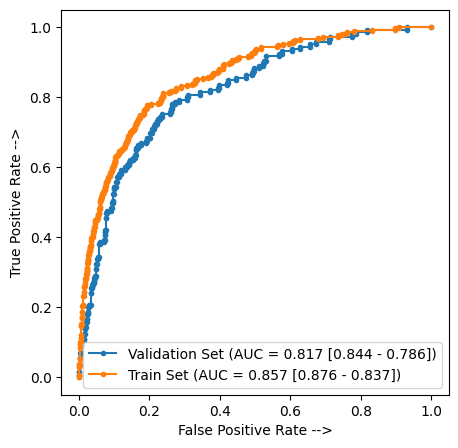

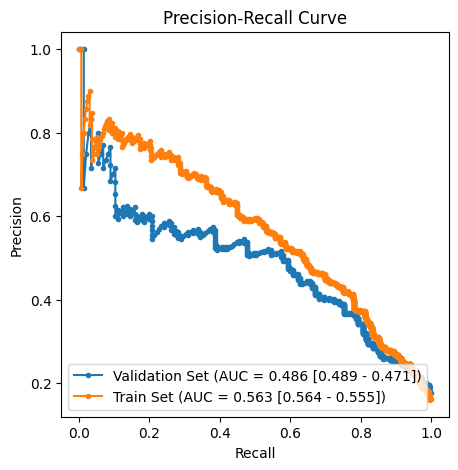

Youden cut-off =  0.07825854
BS train =  0.09237269307382193
BS validation =  0.1158544872232784
BSS train =  0.2713750794336901
BSS validation =  0.1627788441211958
F1 train =  0.5392731535756154
F1 validation =  0.5147058823529412
MCC train =  0.46267366026402973
MCC validation =  0.4115305118016166


In [12]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 18 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 18 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "1.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('1.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        18,"1.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 2 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
11,293980352493624,575119259563355,218759704099816,0,49.614536,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,4.175000e+03,4.175000e+03,4.175000e+03,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,...,4175.000000,4175.00000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4175.000000,4175.000000,4175.000000
mean,5.467487e+14,5.494862e+14,5.478067e+14,0.699162,64.336898,0.246467,0.030659,0.289341,0.064671,0.117126,...,3.160719,0.11497,8.423596,8.860596,8.044316,7.766281,9.231465,1.983952,0.537485,0.091497
std,2.601947e+14,2.588881e+14,2.629547e+14,0.458677,10.318935,0.431005,0.172412,0.453511,0.245973,0.321609,...,2.775982,0.57890,3.127497,4.568043,2.922125,2.434492,4.797455,2.524054,0.643027,0.288349
min,1.002216e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.233161e+14,3.240329e+14,3.178648e+14,0.000000,57.984777,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.00000,6.670000,6.630000,6.460000,6.270000,6.870000,1.000000,0.000000,0.000000
50%,5.427233e+14,5.435475e+14,5.413414e+14,1.000000,64.971189,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.00000,7.980000,8.100000,7.720000,7.490000,8.310000,1.000000,1.000000,0.000000
75%,7.714931e+14,7.732944e+14,7.831679e+14,1.000000,71.679072,0.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.00000,9.640000,10.030000,9.160000,8.900000,10.470000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,14.00000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 382
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.813000e+03,1.813000e+03,1.813000e+03,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,...,1813.000000,1813.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1813.000000,1813.000000,1813.000000
mean,5.441562e+14,5.532109e+14,5.543464e+14,0.723662,63.601498,0.244346,0.030888,0.282405,0.077772,0.113624,...,3.130171,0.088803,8.286937,8.673068,7.927608,7.651892,9.023074,1.963596,0.512410,0.086045
std,2.618198e+14,2.537550e+14,2.649590e+14,0.447309,10.626076,0.429818,0.173062,0.450293,0.267886,0.317441,...,2.731074,0.415419,2.459223,3.137300,2.293819,2.174803,3.435129,2.251269,0.629907,0.280508
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.141327e+14,3.422758e+14,3.178734e+14,0.000000,56.799045,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.520000,6.520000,6.340000,6.140000,6.720000,1.000000,0.000000,0.000000
50%,5.416583e+14,5.550294e+14,5.671949e+14,1.000000,64.356052,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.920000,8.035000,7.610000,7.430000,8.275000,1.000000,0.000000,0.000000
75%,7.761416e+14,7.750597e+14,7.905635e+14,1.000000,70.822903,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.590000,10.020000,9.190000,8.910000,10.320000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 156
Model saved to 2y_model.pkl
Confidence interval for the ML: [0.859 - 0.895]
Confidence interval for the ML: [0.811 - 0.865]


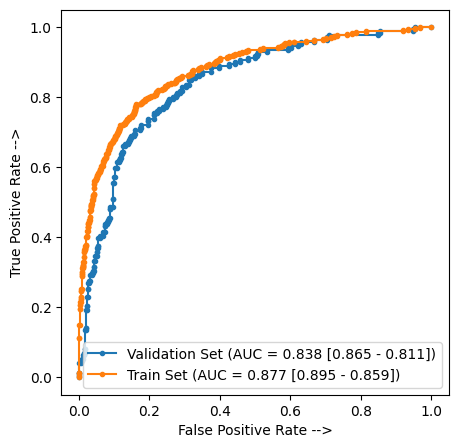

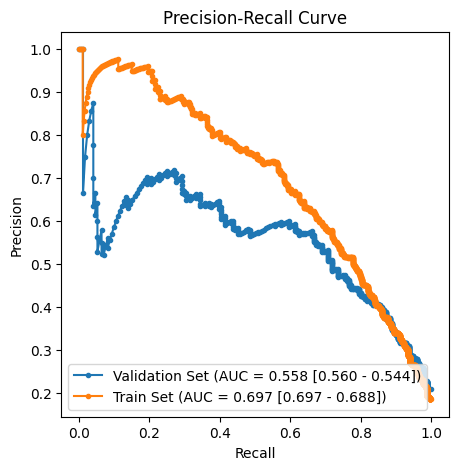

Youden cut-off =  0.16153209
BS train =  0.09082352321409272
BS validation =  0.12131429565349398
BSS train =  0.3891111955262847
BSS validation =  0.2510840853268842
F1 train =  0.6210640608034744
F1 validation =  0.5871121718377088
MCC train =  0.5333924125195803
MCC validation =  0.4702083155393135


In [13]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 2 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 2 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "2y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('2y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        24,"2y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 2.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
13,228317629713460,811844987441852,770852312662831,0,59.609224,0,0,0,0,1,...,2,0,6.46,6.46,6.46,6.46,6.46,1,0,0
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.961000e+03,3.961000e+03,3.961000e+03,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,...,3961.000000,3961.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3961.000000,3961.000000,3961.000000
mean,5.454855e+14,5.482252e+14,5.463791e+14,0.697046,64.327263,0.253219,0.032063,0.297652,0.065388,0.116890,...,3.100985,0.082807,8.395376,8.819073,8.033315,7.762782,9.175219,1.938147,0.524867,0.119667
std,2.600059e+14,2.591146e+14,2.632810e+14,0.459593,10.306865,0.434910,0.176189,0.457283,0.247240,0.321329,...,2.743385,0.499707,3.153723,4.602706,2.961300,2.456080,4.828219,2.504029,0.625591,0.324612
min,1.002216e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.229178e+14,3.227114e+14,3.153354e+14,0.000000,58.020339,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.647500,6.620000,6.457500,6.260000,6.840000,1.000000,0.000000,0.000000
50%,5.407595e+14,5.409397e+14,5.391453e+14,1.000000,64.902296,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.955000,8.060000,7.700000,7.480000,8.275000,1.000000,0.000000,0.000000
75%,7.699798e+14,7.719310e+14,7.829230e+14,1.000000,71.661242,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.600000,9.952500,9.130000,8.900000,10.370000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,14.000000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 474
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.716000e+03,1.716000e+03,1.716000e+03,1716.000000,1716.000000,1716.000000,1716.000000,1716.000000,1716.000000,1716.000000,...,1716.000000,1716.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1716.000000,1716.000000,1716.000000
mean,5.431907e+14,5.540101e+14,5.543921e+14,0.725524,63.630489,0.253497,0.032051,0.286131,0.076923,0.112471,...,3.092657,0.069347,8.270505,8.632904,7.918659,7.649086,8.990854,1.937646,0.504662,0.109557
std,2.617369e+14,2.528962e+14,2.645296e+14,0.446380,10.631942,0.435139,0.176188,0.452083,0.266547,0.316037,...,2.750061,0.385410,2.480889,3.147405,2.312642,2.191368,3.466457,2.278090,0.618925,0.312428
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.116283e+14,3.440817e+14,3.189354e+14,0.000000,56.955801,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.510000,6.475000,6.330000,6.140000,6.690000,1.000000,0.000000,0.000000
50%,5.415222e+14,5.585141e+14,5.645927e+14,1.000000,64.423356,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.880000,8.000000,7.590000,7.420000,8.220000,1.000000,0.000000,0.000000
75%,7.748539e+14,7.748301e+14,7.906233e+14,1.000000,70.827545,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.570000,9.940000,9.185000,8.910000,10.270000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 188
[799149413213770 593017659774118 758763441901849 ... 852685620619370
 932579601868904 613492812780940]


array([799149413213770, 593017659774118, 758763441901849, ...,
       852685620619370, 932579601868904, 613492812780940], dtype=int64)

Model saved to 2.5y_model.pkl
Confidence interval for the ML: [0.856 - 0.889]
Confidence interval for the ML: [0.811 - 0.864]


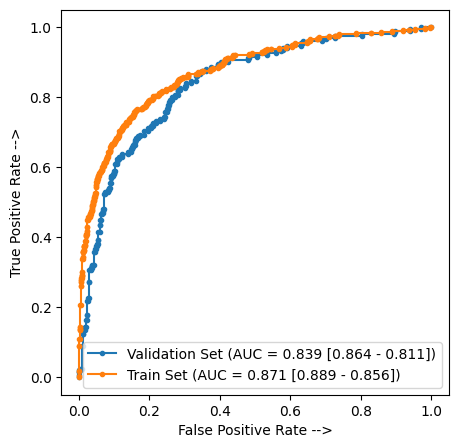

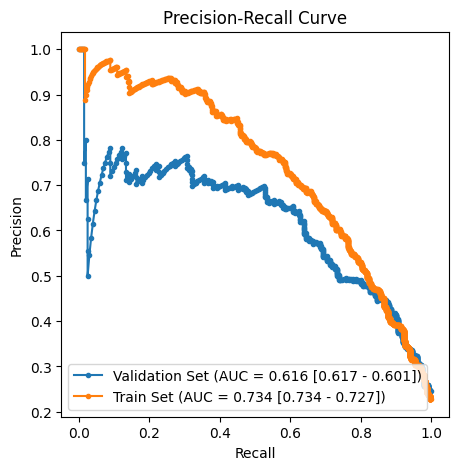

Youden cut-off =  0.22000484
BS train =  0.10547927971067436
BS validation =  0.1305866130542162
BSS train =  0.4002262361602067
BSS validation =  0.2844525769875649
F1 train =  0.6622264509990484
F1 validation =  0.6167400881057269
MCC train =  0.5537668485578346
MCC validation =  0.4828657689856199


In [14]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 30 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 30 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

print(train_patients)
display(train_patients)

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "2.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('2.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        32,"2.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 3 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
13,228317629713460,811844987441852,770852312662831,0,59.609224,0,0,0,0,1,...,2,0,6.46,6.46,6.46,6.46,6.46,1,0,0
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.804000e+03,3.804000e+03,3.804000e+03,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,...,3804.000000,3804.000000,3671.000000,3671.000000,3671.000000,3671.000000,3671.000000,3804.000000,3804.000000,3804.000000
mean,5.445551e+14,5.486110e+14,5.460382e+14,0.696898,64.405060,0.256572,0.032860,0.302313,0.065457,0.116982,...,3.065195,0.070452,8.372858,8.762792,8.030891,7.764489,9.114816,1.891956,0.521030,0.141693
std,2.604238e+14,2.590382e+14,2.640085e+14,0.459659,10.232236,0.436799,0.178294,0.459321,0.247364,0.321441,...,2.738773,0.402176,3.170016,4.600028,2.985222,2.468069,4.824797,2.406199,0.623688,0.348781
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.213212e+14,3.239231e+14,3.131276e+14,0.000000,58.163578,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.630000,6.610000,6.450000,6.260000,6.820000,1.000000,0.000000,0.000000
50%,5.390059e+14,5.409057e+14,5.407729e+14,1.000000,65.002375,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.940000,8.030000,7.700000,7.470000,8.240000,1.000000,0.000000,0.000000
75%,7.698747e+14,7.723971e+14,7.831679e+14,1.000000,71.633438,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.560000,9.895000,9.110000,8.890000,10.275000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,6.000000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 539
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.652000e+03,1.652000e+03,1.652000e+03,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,...,1652.000000,1652.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1652.000000,1652.000000,1652.000000
mean,5.420894e+14,5.524238e+14,5.531878e+14,0.728814,63.638748,0.256053,0.033293,0.291768,0.077482,0.111985,...,3.052663,0.068402,8.257006,8.600706,7.917544,7.652500,8.952738,1.912228,0.500000,0.136199
std,2.612560e+14,2.533649e+14,2.649957e+14,0.444707,10.574408,0.436584,0.179455,0.454714,0.267435,0.315444,...,2.764140,0.388563,2.479402,3.116574,2.320693,2.197917,3.441214,2.275974,0.618217,0.343103
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.117523e+14,3.420748e+14,3.172997e+14,0.000000,57.177462,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.500000,6.457500,6.330000,6.150000,6.660000,1.000000,0.000000,0.000000
50%,5.396286e+14,5.542210e+14,5.620252e+14,1.000000,64.387444,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.860000,7.980000,7.580000,7.420000,8.190000,1.000000,0.000000,0.000000
75%,7.737598e+14,7.745628e+14,7.915161e+14,1.000000,70.796275,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.560000,9.900000,9.182500,8.912500,10.222500,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 225
Model saved to 3y_model.pkl
Confidence interval for the ML: [0.860 - 0.891]
Confidence interval for the ML: [0.829 - 0.877]


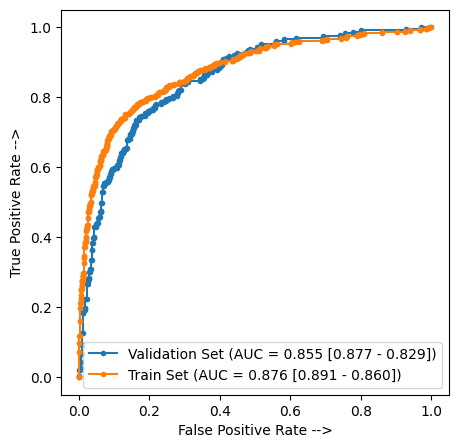

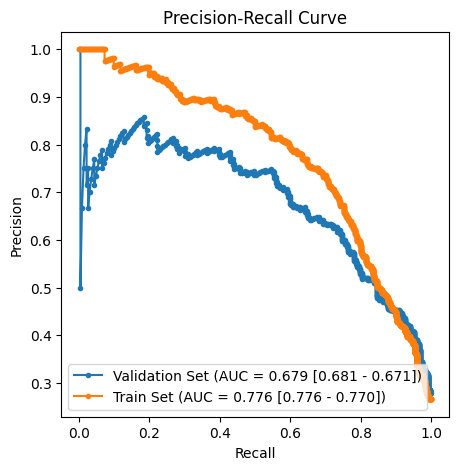

Youden cut-off =  0.32660013
BS train =  0.11046283892186007
BS validation =  0.1307997216574403
BSS train =  0.43266614061265907
BSS validation =  0.3398966953963236
F1 train =  0.709620476610768
F1 validation =  0.6694045174537987
MCC train =  0.5987171275840177
MCC validation =  0.537232883967173


In [15]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 3 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 3 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "3y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('3y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        36,"3y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 3.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
20,324343382320396,370463371363099,940554944343033,1,69.727228,0,0,0,0,0,...,5,0,9.57,9.57,9.57,9.57,9.57,1,0,1
27,829642584990713,515578690895512,586275475952147,1,67.869739,0,0,0,0,0,...,3,0,12.59,12.85,12.33,12.33,12.85,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.624000e+03,3.624000e+03,3.624000e+03,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,...,3624.000000,3624.000000,3492.000000,3492.000000,3492.000000,3492.000000,3492.000000,3624.000000,3624.000000,3624.000000
mean,5.446580e+14,5.473283e+14,5.442448e+14,0.697572,64.498607,0.258002,0.033389,0.303808,0.065949,0.118102,...,3.045254,0.066225,8.336022,8.701561,8.010160,7.745435,9.057443,1.877208,0.524558,0.168046
std,2.604222e+14,2.585423e+14,2.633355e+14,0.459373,10.172260,0.437596,0.179674,0.459964,0.248228,0.322773,...,2.757399,0.393890,2.922299,4.219938,2.885043,2.325605,4.479563,2.427210,0.627332,0.373959
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.223949e+14,3.237471e+14,3.129498e+14,0.000000,58.286686,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.610000,6.600000,6.447500,6.257500,6.800000,1.000000,0.000000,0.000000
50%,5.379214e+14,5.382641e+14,5.383563e+14,1.000000,65.093043,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.920000,8.000000,7.680000,7.470000,8.220000,1.000000,0.000000,0.000000
75%,7.685932e+14,7.718860e+14,7.781553e+14,1.000000,71.641797,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.530000,9.842500,9.102500,8.890000,10.205000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,6.000000,97.670000,159.120000,113.690000,54.810000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 609
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.576000e+03,1.576000e+03,1.576000e+03,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,...,1576.000000,1576.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1576.000000,1576.000000,1576.000000
mean,5.412980e+14,5.523419e+14,5.548341e+14,0.728426,63.627975,0.258249,0.032360,0.294416,0.077411,0.114213,...,3.016497,0.062817,8.232302,8.570774,7.901325,7.634341,8.921082,1.895939,0.504442,0.164975
std,2.616455e+14,2.542069e+14,2.653354e+14,0.444912,10.572137,0.437810,0.177012,0.455925,0.267328,0.318171,...,2.764121,0.362339,2.484837,3.121861,2.331058,2.208629,3.441803,2.276859,0.622320,0.371275
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.113814e+14,3.419365e+14,3.183097e+14,0.000000,57.186539,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.480000,6.430000,6.320000,6.130000,6.640000,1.000000,0.000000,0.000000
50%,5.362915e+14,5.524253e+14,5.641318e+14,1.000000,64.415118,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.840000,7.950000,7.580000,7.410000,8.160000,1.000000,0.000000,0.000000
75%,7.739211e+14,7.768467e+14,7.944964e+14,1.000000,70.809148,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.510000,9.870000,9.130000,8.900000,10.190000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 260
Model saved to 3.5y_model.pkl
Confidence interval for the ML: [0.864 - 0.894]
Confidence interval for the ML: [0.839 - 0.883]


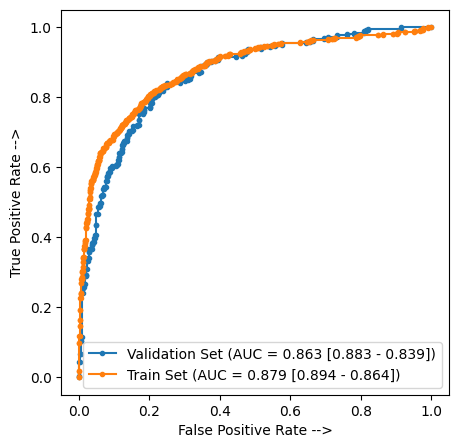

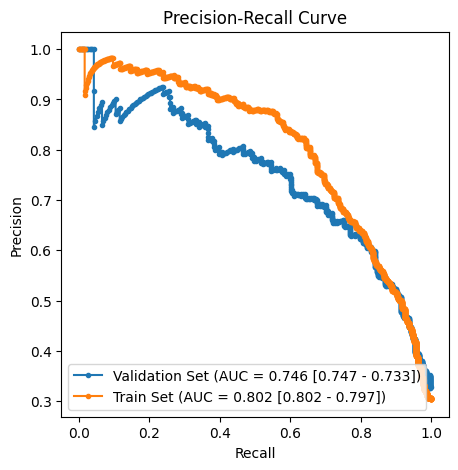

Youden cut-off =  0.24994366
BS train =  0.11732540867616784
BS validation =  0.1332229718999459
BSS train =  0.4433965846270954
BSS validation =  0.37490163868191406
F1 train =  0.7118155619596541
F1 validation =  0.6973684210526315
MCC train =  0.5740182026420736
MCC validation =  0.5463704169758027


In [16]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 42 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 42 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "3.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('3.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        42,"3.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 4 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
20,324343382320396,370463371363099,940554944343033,1,69.727228,0,0,0,0,0,...,5,0,9.57,9.57,9.57,9.57,9.57,1,0,1
27,829642584990713,515578690895512,586275475952147,1,67.869739,0,0,0,0,0,...,3,0,12.59,12.85,12.33,12.33,12.85,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.341000e+03,3.341000e+03,3.341000e+03,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,...,3341.000000,3341.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3341.000000,3341.000000,3341.000000
mean,5.451205e+14,5.475815e+14,5.438388e+14,0.697695,64.679619,0.268183,0.035019,0.309488,0.068243,0.119126,...,3.032625,0.063753,8.308801,8.661159,7.989645,7.735662,9.007023,1.869799,0.507333,0.200239
std,2.600725e+14,2.588980e+14,2.634167e+14,0.459325,10.164531,0.443080,0.183856,0.462352,0.252200,0.323985,...,2.792925,0.383578,2.953814,4.235054,2.938237,2.351938,4.468237,2.451589,0.632235,0.400239
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.234434e+14,3.246622e+14,3.146742e+14,0.000000,58.480377,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.600000,6.570000,6.420000,6.215000,6.780000,1.000000,0.000000,0.000000
50%,5.376930e+14,5.381299e+14,5.383563e+14,1.000000,65.324302,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.890000,7.970000,7.650000,7.450000,8.190000,1.000000,0.000000,0.000000
75%,7.694671e+14,7.736161e+14,7.780231e+14,1.000000,71.716020,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.515000,9.810000,9.090000,8.900000,10.170000,2.000000,1.000000,0.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,6.000000,97.670000,159.120000,113.690000,54.810000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 669
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.468000e+03,1.468000e+03,1.468000e+03,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,...,1468.000000,1468.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1468.000000,1468.000000,1468.000000
mean,5.395870e+14,5.499165e+14,5.560030e+14,0.729564,63.584843,0.271798,0.033379,0.305177,0.076294,0.112398,...,2.982289,0.054496,8.222271,8.558039,7.898893,7.641841,8.876537,1.861717,0.493869,0.198229
std,2.618474e+14,2.532145e+14,2.651596e+14,0.444336,10.656511,0.445038,0.179685,0.460639,0.265559,0.315963,...,2.591152,0.327807,2.485783,3.103409,2.340824,2.211225,3.351130,2.065216,0.628208,0.398801
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.111500e+14,3.412656e+14,3.177956e+14,0.000000,56.955801,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.482500,6.430000,6.320000,6.140000,6.640000,1.000000,0.000000,0.000000
50%,5.339776e+14,5.507919e+14,5.641318e+14,1.000000,64.276858,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.840000,7.945000,7.580000,7.405000,8.150000,1.000000,0.000000,0.000000
75%,7.736700e+14,7.704568e+14,7.948978e+14,1.000000,70.899864,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.480000,9.840000,9.130000,8.900000,10.137500,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,26.000000,12.000000,1.000000


Events in validation dataset: 291
Model saved to 4y_model.pkl
Confidence interval for the ML: [0.864 - 0.892]
Confidence interval for the ML: [0.830 - 0.876]


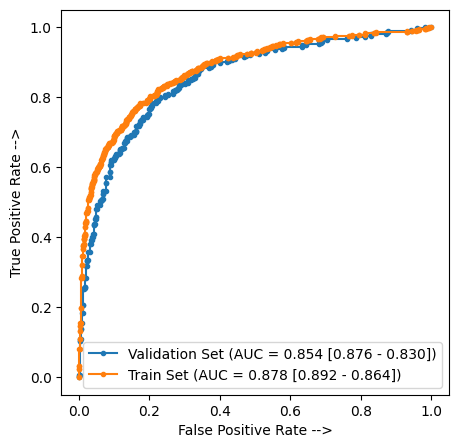

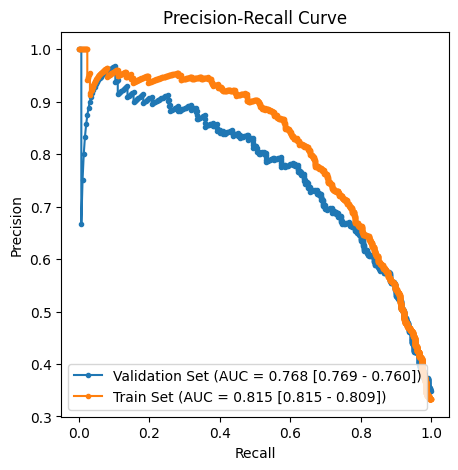

Youden cut-off =  0.31099978
BS train =  0.12354360683777127
BS validation =  0.14190054710701538
BSS train =  0.44266740371382873
BSS validation =  0.37190336780526356
F1 train =  0.7340876944837341
F1 validation =  0.7138263665594855
MCC train =  0.5934274467754646
MCC validation =  0.5502643503657149


In [17]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 4 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 4 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "4y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('4y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        48,"4y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 4.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
20,324343382320396,370463371363099,940554944343033,1,69.727228,0,0,0,0,0,...,5,0,9.57,9.57,9.57,9.57,9.57,1,0,1
27,829642584990713,515578690895512,586275475952147,1,67.869739,0,0,0,0,0,...,3,0,12.59,12.85,12.33,12.33,12.85,2,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
35,189030997788613,310476878984777,414231075964514,1,57.105171,0,0,0,0,0,...,2,0,5.82,5.78,5.86,5.78,5.86,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.987000e+03,2.987000e+03,2.987000e+03,2987.000000,2987.000000,2987.000000,2987.000000,2987.000000,2987.000000,2987.000000,...,2987.000000,2987.000000,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000,2987.000000,2987.000000,2987.000000
mean,5.449640e+14,5.487929e+14,5.405625e+14,0.695681,64.864069,0.283562,0.036491,0.323736,0.070305,0.119518,...,3.042518,0.068296,8.326693,8.699615,8.000371,7.737050,9.050147,1.895547,0.491798,0.241714
std,2.600798e+14,2.586231e+14,2.625329e+14,0.460195,10.190817,0.450802,0.187541,0.467979,0.255703,0.324451,...,2.885839,0.401799,3.002316,4.370587,2.998363,2.352001,4.607381,2.549143,0.638817,0.428194
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.235122e+14,3.271683e+14,3.128990e+14,0.000000,58.522100,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.600000,6.580000,6.430000,6.220000,6.792500,1.000000,0.000000,0.000000
50%,5.370356e+14,5.413330e+14,5.320751e+14,1.000000,65.558573,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.910000,7.995000,7.670000,7.450000,8.200000,1.000000,0.000000,0.000000
75%,7.697235e+14,7.727293e+14,7.745391e+14,1.000000,71.969823,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.550000,9.847500,9.060000,8.900000,10.200000,2.000000,1.000000,0.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,6.000000,97.670000,159.120000,113.690000,54.810000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 722
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.332000e+03,1.332000e+03,1.332000e+03,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,...,1332.000000,1332.000000,1286.000000,1286.000000,1286.000000,1286.000000,1286.000000,1332.000000,1332.000000,1332.000000
mean,5.421296e+14,5.493487e+14,5.524124e+14,0.728979,63.604314,0.279279,0.036036,0.312312,0.077327,0.112613,...,2.992492,0.052553,8.201734,8.538398,7.879907,7.618694,8.861073,1.878378,0.479730,0.236486
std,2.608098e+14,2.538554e+14,2.670032e+14,0.444654,10.654493,0.448814,0.186450,0.463610,0.267210,0.316237,...,2.667094,0.298155,2.506496,3.139267,2.352741,2.213590,3.403482,2.123585,0.631298,0.425084
min,1.005663e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.138330e+14,3.412656e+14,3.100673e+14,0.000000,57.170242,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.460000,6.420000,6.270000,6.122500,6.620000,1.000000,0.000000,0.000000
50%,5.388693e+14,5.489399e+14,5.557077e+14,1.000000,64.303637,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.835000,7.925000,7.550000,7.385000,8.140000,1.000000,0.000000,0.000000
75%,7.748539e+14,7.696340e+14,7.946986e+14,1.000000,70.890763,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.410000,9.797500,9.117500,8.887500,10.117500,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,25.130000,28.820000,27.950000,21.440000,36.680000,26.000000,12.000000,1.000000


Events in validation dataset: 315
Model saved to 4.5y_model.pkl
Confidence interval for the ML: [0.872 - 0.898]
Confidence interval for the ML: [0.832 - 0.876]


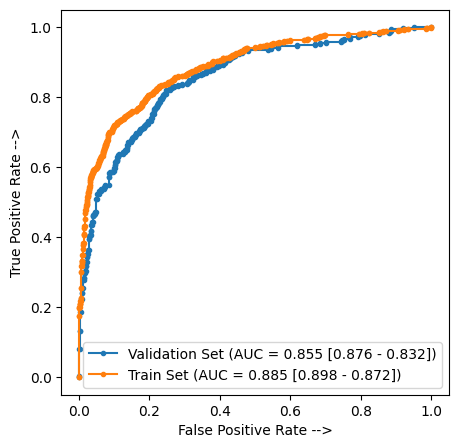

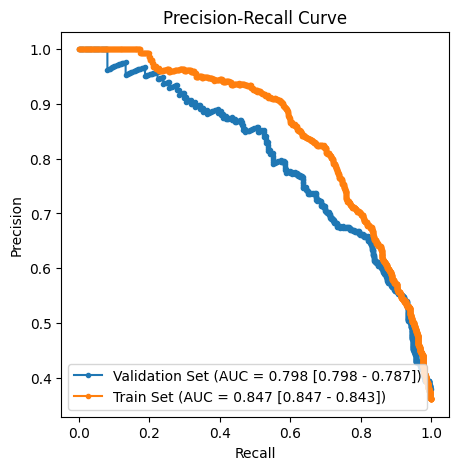

Youden cut-off =  0.49371502
BS train =  0.12388716795703412
BS validation =  0.14554359416174295
BSS train =  0.4625535840464968
BSS validation =  0.3737972429720434
F1 train =  0.7586705202312138
F1 validation =  0.6920415224913494
MCC train =  0.6354214118503264
MCC validation =  0.5349499686457669


In [18]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 54 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 54 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "4.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('4.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        54,"4.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
20,324343382320396,370463371363099,940554944343033,1,69.727228,0,0,0,0,0,...,5,0,9.57,9.57,9.57,9.57,9.57,1,0,1
27,829642584990713,515578690895512,586275475952147,1,67.869739,0,0,0,0,0,...,3,0,12.59,12.85,12.33,12.33,12.85,2,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
35,189030997788613,310476878984777,414231075964514,1,57.105171,0,0,0,0,0,...,2,0,5.82,5.78,5.86,5.78,5.86,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.665000e+03,2.665000e+03,2.665000e+03,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,...,2665.000000,2665.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2665.000000,2665.000000,2665.000000
mean,5.470242e+14,5.495885e+14,5.398765e+14,0.699812,64.937646,0.297936,0.039024,0.335835,0.073546,0.118574,...,3.049531,0.074296,8.342997,8.728552,8.008266,7.746732,9.083550,1.921951,0.477298,0.290432
std,2.606427e+14,2.582568e+14,2.641363e+14,0.458425,10.165244,0.457437,0.193689,0.472370,0.261080,0.323347,...,2.956610,0.421499,3.053774,4.498729,3.056124,2.369224,4.737374,2.617492,0.642255,0.454047
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.251299e+14,3.286955e+14,3.102023e+14,0.000000,58.631155,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.620000,6.610000,6.440000,6.250000,6.840000,1.000000,0.000000,0.000000
50%,5.408082e+14,5.448103e+14,5.295062e+14,1.000000,65.560228,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.930000,8.010000,7.690000,7.470000,8.200000,1.000000,0.000000,0.000000
75%,7.740501e+14,7.732205e+14,7.774795e+14,1.000000,71.971111,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.550000,9.860000,9.060000,8.890000,10.240000,2.000000,1.000000,1.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,6.000000,97.670000,159.120000,113.690000,54.810000,159.120000,44.000000,15.000000,1.000000


Events in training dataset: 774
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.206000e+03,1.206000e+03,1.206000e+03,1206.000000,1206.000000,1206.00000,1206.000000,1206.000000,1206.000000,1206.000000,...,1206.000000,1206.000000,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,1206.000000,1206.000000,1206.000000
mean,5.409172e+14,5.516315e+14,5.481662e+14,0.727197,63.742651,0.28607,0.034826,0.321725,0.077944,0.117745,...,2.985904,0.058043,8.196260,8.554867,7.865426,7.596621,8.871015,1.899668,0.465174,0.282753
std,2.592228e+14,2.547801e+14,2.660082e+14,0.445585,10.760403,0.45211,0.183415,0.467332,0.268194,0.322439,...,2.715983,0.312847,2.526657,3.200002,2.385175,2.235847,3.389236,2.189917,0.640304,0.450524
min,1.005663e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.155095e+14,3.420609e+14,3.102144e+14,0.000000,57.230500,0.00000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.410000,6.400000,6.230000,6.070000,6.600000,1.000000,0.000000,0.000000
50%,5.339776e+14,5.542210e+14,5.498323e+14,1.000000,64.611994,0.00000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.840000,7.930000,7.550000,7.380000,8.140000,1.000000,0.000000,0.000000
75%,7.717285e+14,7.742953e+14,7.917278e+14,1.000000,71.275756,1.00000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.405000,9.800000,9.105000,8.870000,10.150000,2.000000,1.000000,1.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.00000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,25.130000,28.820000,27.950000,21.440000,28.820000,26.000000,12.000000,1.000000


Events in validation dataset: 341
Model saved to 5y_model.pkl
Confidence interval for the ML: [0.875 - 0.901]
Confidence interval for the ML: [0.834 - 0.878]


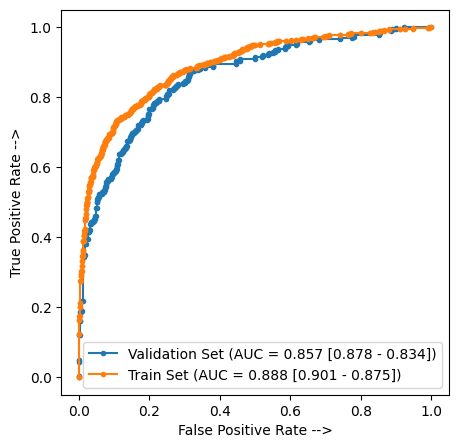

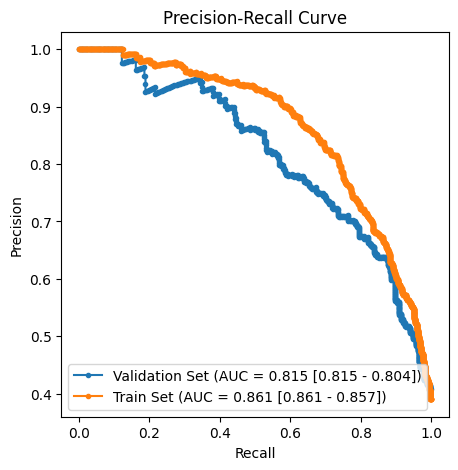

Youden cut-off =  0.50208163
BS train =  0.12614934539962308
BS validation =  0.1467151711725343
BSS train =  0.46954330975614267
BSS validation =  0.3832973602072858
F1 train =  0.7719063545150502
F1 validation =  0.7106109324758841
MCC train =  0.6407620441446473
MCC validation =  0.543645054562558


In [19]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 5 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 5 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        60,"5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 5.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
20,324343382320396,370463371363099,940554944343033,1,69.727228,0,0,0,0,0,...,5,0,9.57,9.57,9.57,9.57,9.57,1,0,1
27,829642584990713,515578690895512,586275475952147,1,67.869739,0,0,0,0,0,...,3,0,12.59,12.85,12.33,12.33,12.85,2,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
35,189030997788613,310476878984777,414231075964514,1,57.105171,0,0,0,0,0,...,2,0,5.82,5.78,5.86,5.78,5.86,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,236200154705279,975682079550853,977484527323956,1,59.746187,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.301000e+03,2.301000e+03,2.301000e+03,2301.000000,2301.000000,2301.000000,2301.000000,2301.000000,2301.000000,2301.000000,...,2301.000000,2301.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2301.000000,2301.000000,2301.000000
mean,5.475159e+14,5.502107e+14,5.387171e+14,0.702303,65.086343,0.304650,0.039983,0.343329,0.076054,0.126901,...,3.100826,0.083007,8.381577,8.796461,8.024153,7.743071,9.183648,1.997827,0.465450,0.351586
std,2.602685e+14,2.585758e+14,2.624524e+14,0.457345,10.156884,0.460359,0.195961,0.474923,0.265142,0.332935,...,3.092108,0.449708,3.157363,4.727358,3.170973,2.403982,4.977256,2.758464,0.584028,0.477569
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.259695e+14,3.275119e+14,3.131699e+14,0.000000,58.639686,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.630000,6.610000,6.450000,6.250000,6.850000,1.000000,0.000000,0.000000
50%,5.408082e+14,5.467726e+14,5.197529e+14,1.000000,65.562022,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.960000,8.040000,7.710000,7.470000,8.250000,1.000000,0.000000,0.000000
75%,7.724361e+14,7.736161e+14,7.706892e+14,1.000000,72.113742,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.590000,9.900000,9.060000,8.860000,10.330000,2.000000,1.000000,1.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,6.000000,97.670000,159.120000,113.690000,54.810000,159.120000,44.000000,10.000000,1.000000


Events in training dataset: 809
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7420,561218996274667,399086079647637,417397079591851,1,41.179992,0,0,0,0,0,...,1,0,8.90,8.90,8.90,8.90,8.90,1,0,0
7423,632653329486333,664694231144080,564817824337315,1,72.056123,0,0,1,0,0,...,7,0,7.42,4.38,5.69,4.38,10.28,7,1,0
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.056000e+03,1.056000e+03,1.056000e+03,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,...,1056.000000,1056.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1056.000000,1056.000000,1056.000000
mean,5.391887e+14,5.499577e+14,5.433811e+14,0.723485,63.752320,0.297348,0.035985,0.329545,0.079545,0.116477,...,3.019886,0.064394,8.225807,8.601339,7.881831,7.601909,8.928327,1.942235,0.452652,0.337121
std,2.608798e+14,2.542588e+14,2.628028e+14,0.447486,10.814380,0.457308,0.186341,0.470271,0.270716,0.320948,...,2.821479,0.331049,2.538161,3.239306,2.392415,2.247301,3.427433,2.291024,0.654284,0.472951
min,1.005663e+14,1.011109e+14,1.004285e+14,0.000000,30.961136,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.113814e+14,3.419491e+14,3.100673e+14,0.000000,57.086784,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.430000,6.427500,6.240000,6.077500,6.620000,1.000000,0.000000,0.000000
50%,5.286895e+14,5.477384e+14,5.408684e+14,1.000000,64.415118,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.875000,7.995000,7.575000,7.395000,8.180000,1.000000,0.000000,0.000000
75%,7.723302e+14,7.711682e+14,7.810224e+14,1.000000,71.451771,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.482500,9.840000,9.132500,8.882500,10.200000,2.000000,1.000000,1.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,25.130000,28.820000,27.950000,21.440000,28.820000,26.000000,12.000000,1.000000


Events in validation dataset: 356
Model saved to 5.5y_model.pkl
Confidence interval for the ML: [0.870 - 0.895]
Confidence interval for the ML: [0.841 - 0.884]


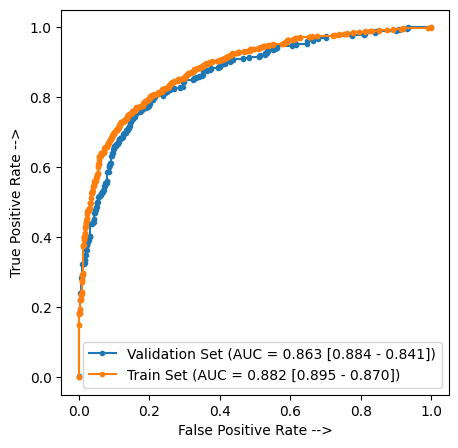

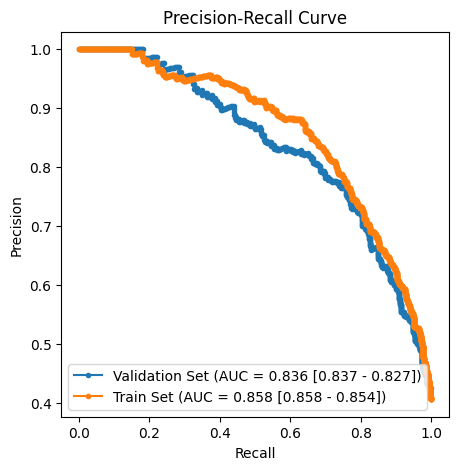

Youden cut-off =  0.5092986
BS train =  0.13214417526206362
BS validation =  0.14383020004416197
BSS train =  0.4522423855655957
BSS validation =  0.4049859171456943
F1 train =  0.7661755285073671
F1 validation =  0.7399380804953561
MCC train =  0.6218034614919689
MCC validation =  0.5821208523384598


In [20]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 66 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 66 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "5.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('5.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        66,"5.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 6 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
20,324343382320396,370463371363099,940554944343033,1,69.727228,0,0,0,0,0,...,5,0,9.57,9.57,9.57,9.57,9.57,1,0,1
27,829642584990713,515578690895512,586275475952147,1,67.869739,0,0,0,0,0,...,3,0,12.59,12.85,12.33,12.33,12.85,2,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
35,189030997788613,310476878984777,414231075964514,1,57.105171,0,0,0,0,0,...,2,0,5.82,5.78,5.86,5.78,5.86,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,236200154705279,975682079550853,977484527323956,1,59.746187,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.951000e+03,1.951000e+03,1.951000e+03,1951.000000,1951.000000,1951.000000,1951.000000,1951.000000,1951.000000,1951.000000,...,1951.000000,1951.000000,1872.000000,1872.000000,1872.000000,1872.00000,1872.000000,1951.000000,1951.000000,1951.000000
mean,5.490168e+14,5.546964e+14,5.417977e+14,0.704254,65.397768,0.294208,0.040492,0.338801,0.077396,0.134290,...,3.177345,0.093285,8.424658,8.865064,8.052585,7.75071,9.277762,2.080984,0.473091,0.429523
std,2.587295e+14,2.597670e+14,2.617371e+14,0.456494,10.251885,0.455803,0.197161,0.473423,0.267288,0.341051,...,3.216356,0.483058,3.284928,4.973164,3.321366,2.45233,5.236226,2.861164,0.594995,0.495135
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,1.670000,0.830000,0.54000,2.440000,0.000000,0.000000,0.000000
25%,3.323292e+14,3.323480e+14,3.186072e+14,0.000000,58.934055,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.660000,6.630000,6.497500,6.26000,6.920000,1.000000,0.000000,0.000000
50%,5.417800e+14,5.560347e+14,5.319696e+14,1.000000,65.900801,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,8.000000,8.090000,7.750000,7.49000,8.295000,1.000000,0.000000,0.000000
75%,7.721637e+14,7.849536e+14,7.743662e+14,1.000000,72.391466,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.612500,9.912500,9.110000,8.90000,10.430000,2.000000,1.000000,1.000000
max,9.995015e+14,9.994679e+14,9.984975e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,6.000000,97.670000,159.120000,113.690000,54.81000,159.120000,44.000000,10.000000,1.000000


Events in training dataset: 838
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7,0,7.28,7.28,7.28,7.28,7.28,1,0,1
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7420,561218996274667,399086079647637,417397079591851,1,41.179992,0,0,0,0,0,...,1,0,8.90,8.90,8.90,8.90,8.90,1,0,0
7423,632653329486333,664694231144080,564817824337315,1,72.056123,0,0,1,0,0,...,7,0,7.42,4.38,5.69,4.38,10.28,7,1,0
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,9.100000e+02,9.100000e+02,9.100000e+02,910.000000,910.000000,910.00000,910.000000,910.000000,910.000000,910.000000,...,910.000000,910.000000,876.000000,876.000000,876.000000,876.000000,876.000000,910.000000,910.000000,910.000000
mean,5.462312e+14,5.554403e+14,5.454067e+14,0.720879,63.947559,0.30000,0.038462,0.330769,0.079121,0.123077,...,3.104396,0.073626,8.222317,8.614053,7.871210,7.563744,8.971861,2.031868,0.459341,0.401099
std,2.610918e+14,2.523725e+14,2.626929e+14,0.448814,11.005633,0.45851,0.192413,0.470749,0.270076,0.328706,...,2.990834,0.354240,2.517119,3.232466,2.408996,2.229304,3.444024,2.433737,0.673231,0.490390
min,1.005663e+14,1.011109e+14,1.004285e+14,0.000000,30.961136,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.920000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.166652e+14,3.480498e+14,3.126874e+14,0.000000,57.141579,0.00000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.407500,6.420000,6.230000,6.047500,6.620000,1.000000,0.000000,0.000000
50%,5.388693e+14,5.568147e+14,5.408684e+14,1.000000,64.611994,0.00000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.855000,7.980000,7.550000,7.330000,8.200000,1.000000,0.000000,0.000000
75%,7.772069e+14,7.771296e+14,7.872355e+14,1.000000,71.853351,1.00000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.502500,9.845000,9.092500,8.862500,10.262500,2.000000,1.000000,1.000000
max,9.986089e+14,9.987505e+14,9.987299e+14,1.000000,91.993512,1.00000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,25.130000,28.820000,27.950000,21.440000,28.820000,26.000000,12.000000,1.000000


Events in validation dataset: 365
Model saved to 6y_model.pkl
Confidence interval for the ML: [0.863 - 0.889]
Confidence interval for the ML: [0.836 - 0.879]


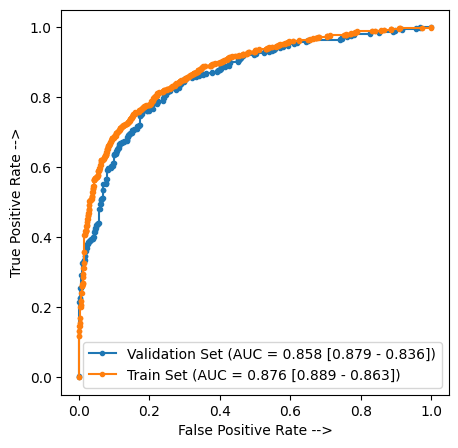

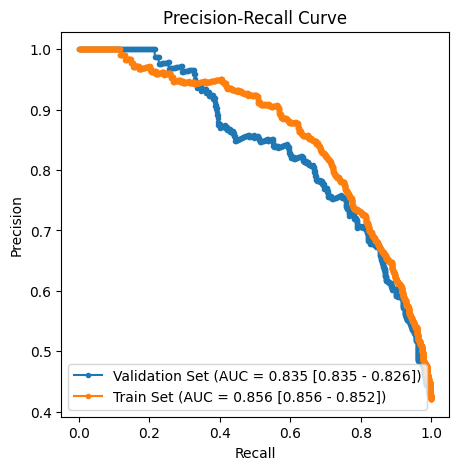

Youden cut-off =  0.45187366
BS train =  0.13701044320932254
BS validation =  0.14851294284735164
BSS train =  0.43785076674578227
BSS validation =  0.3902360172176561
F1 train =  0.7664670658682634
F1 validation =  0.7517730496453899
MCC train =  0.6022829319864823
MCC validation =  0.5726556231782134


In [21]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 6 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 6 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "6y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('6y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        72,"6y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))

